<font size="5">Retail Store Sales Demand and Forecast</font>

**Author:** *Ibrahim Munirudeen Oshone*


In [ ]:
    !pip install xgboost
    !pip install tensorflow


In [16]:
#  Import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

import joblib


In [18]:
# Load Dataset 
df = pd.read_csv("retail_store_inventory.csv", parse_dates=["Date"])
df.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


**Exploratory Data Analysis (EDA)**


In [21]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 non-null  float64   

In [23]:
# Check missing values
print(df.isnull().sum())


Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


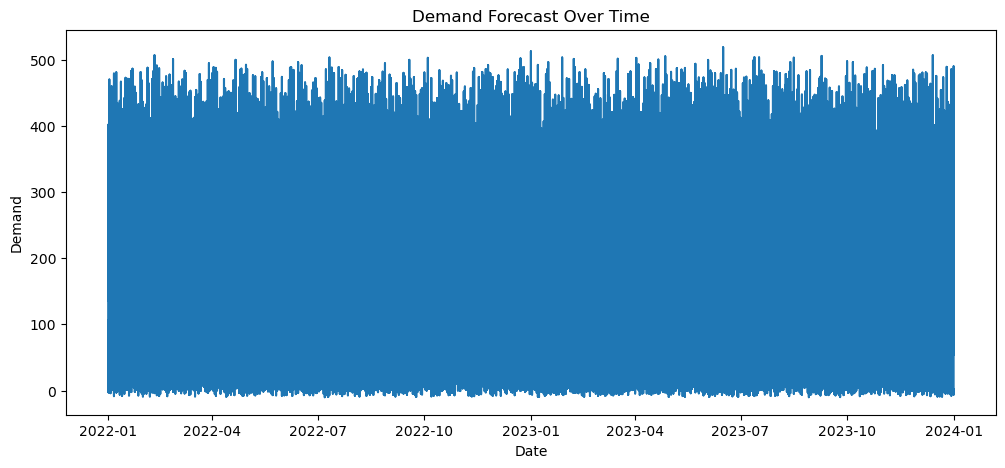

In [25]:
# Sales trend over time
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Demand Forecast"])
plt.title("Demand Forecast Over Time")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()


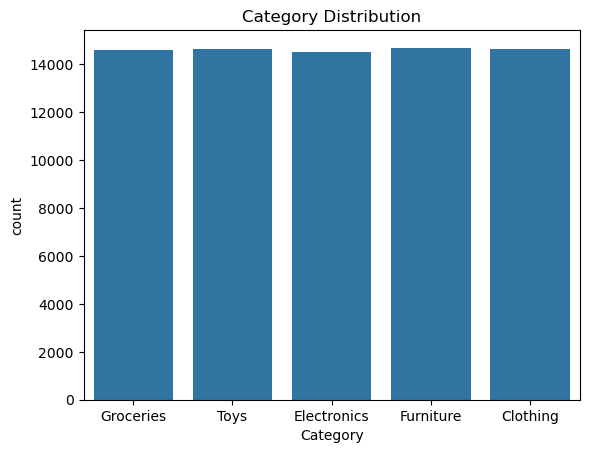

In [27]:
# Category distribution
sns.countplot(data=df, x="Category")
plt.title("Category Distribution")
plt.show()


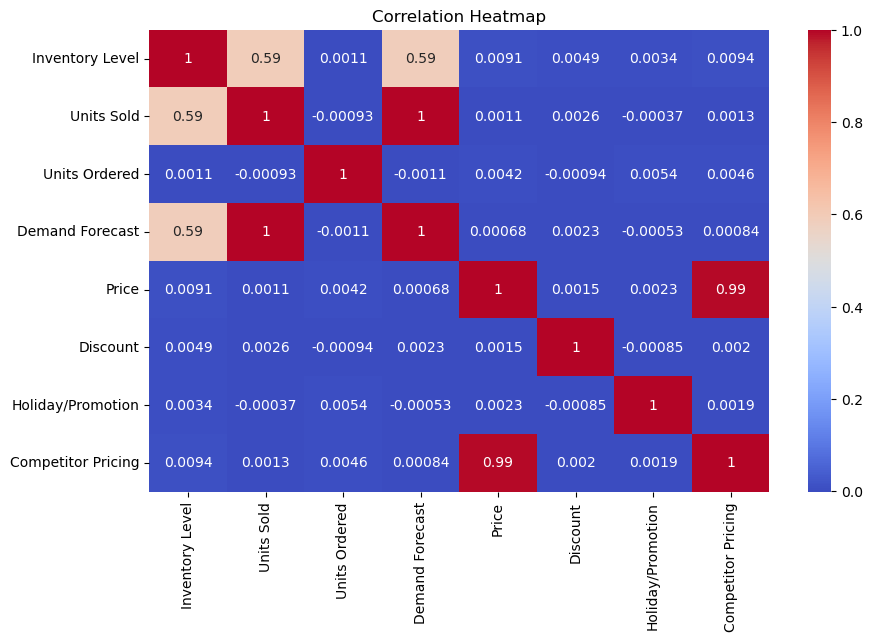

In [29]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


**Preprocessing**


In [32]:
# Encode categorical features
encoders = {}
cat_cols = ["Category", "Region", "Weather Condition", "Seasonality"]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le   # store the fitted encoder



In [34]:
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,3,1,231,127,55,135.47,33.50,20,1,0,29.69,0
1,2022-01-01,S001,P0002,4,2,204,150,66,144.04,63.01,20,3,0,66.16,0
2,2022-01-01,S001,P0003,4,3,102,65,51,74.02,27.99,10,3,1,31.32,2
3,2022-01-01,S001,P0004,4,1,469,61,164,62.18,32.72,10,0,1,34.74,0
4,2022-01-01,S001,P0005,1,0,166,14,135,9.26,73.64,0,3,0,68.95,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,2,0,96,8,127,18.46,73.73,20,2,0,72.45,3
73096,2024-01-01,S005,P0017,4,1,313,51,101,48.43,82.57,10,0,0,83.78,0
73097,2024-01-01,S005,P0018,0,3,278,36,151,39.65,11.11,10,1,0,10.91,3
73098,2024-01-01,S005,P0019,4,0,374,264,21,270.52,53.14,20,1,0,55.80,1


In [36]:
# checking for duplicates
duplicate_rows = df[df.duplicated()]
print("Duplicate rows based on all columns:")
print(duplicate_rows)
duplicate_rows

Duplicate rows based on all columns:
Empty DataFrame
Columns: [Date, Store ID, Product ID, Category, Region, Inventory Level, Units Sold, Units Ordered, Demand Forecast, Price, Discount, Weather Condition, Holiday/Promotion, Competitor Pricing, Seasonality]
Index: []


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality


In [38]:
# Features & Target
features = ["Inventory Level", "Units Sold", "Units Ordered", "Price", "Discount",
            "Competitor Pricing", "Category", "Region", "Weather Condition", "Seasonality", "Holiday/Promotion"]
target = "Demand Forecast"

X = df[features]
y = df[target]


In [40]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


**Preprocessing**


In [43]:
# Decision Tree Model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Evaluation
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds) * 100  # percentage form

print("Decision Tree → RMSE:", dt_rmse, "MAE:", dt_mae, "R² Score:", dt_r2, "%")

# Compare actual vs predicted
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": dt_preds
}).reset_index(drop=True)

print("\nActual vs Predicted:")
print(comparison_df.head(20))  # show first 20 rows


Decision Tree → RMSE: 9.556418218574146 MAE: 8.063178822292196 R² Score: 99.23361717640095 %

Actual vs Predicted:
    Actual   Predicted
0    73.46   79.715823
1   338.72  329.184004
2    58.93   68.802151
3     8.99   10.571830
4   287.47  292.267702
5    94.88  102.519968
6    49.98   57.964723
7    73.25   79.715823
8    41.57   40.546034
9   103.57  113.584766
10   34.83   21.167275
11  119.04  102.519968
12  131.71  138.661267
13  315.68  310.021503
14  379.54  368.488687
15  156.75  138.661267
16   79.78   68.802151
17  240.33  230.044002
18   48.91   48.278688
19    5.93   10.571830


In [45]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds) * 100  # percentage

print("XGBoost → RMSE:", xgb_rmse, "MAE:", xgb_mae, "R² Score:", xgb_r2, "%")

# Compare actual vs predicted
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": xgb_preds
}).reset_index(drop=True)

print("\nActual vs Predicted:")
print(comparison_df.head(20))  # show first 20 rows


XGBoost → RMSE: 8.791957546982813 MAE: 7.592907980056967 R² Score: 99.35132578899952 %

Actual vs Predicted:
    Actual   Predicted
0    73.46   83.817467
1   338.72  340.071838
2    58.93   64.853172
3     8.99    5.325881
4   287.47  291.203033
5    94.88  100.634537
6    49.98   61.908363
7    73.25   80.108284
8    41.57   40.898460
9   103.57  113.921410
10   34.83   24.416588
11  119.04  105.864815
12  131.71  140.063522
13  315.68  320.040985
14  379.54  368.789734
15  156.75  143.085297
16   79.78   72.008850
17  240.33  234.332169
18   48.91   44.914413
19    5.93    9.224411


In [47]:
# Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds) * 100

print("Random Forest → RMSE:", rf_rmse, "MAE:", rf_mae, "R² Score:", rf_r2, "%")

# Compare actual vs predicted
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": rf_preds
}).reset_index(drop=True)

print("\nActual vs Predicted:")
print(comparison_df.head(20))  # show first 20 rows


Random Forest → RMSE: 8.814139256269605 MAE: 7.61248322937209 R² Score: 99.34804850889101 %

Actual vs Predicted:
    Actual   Predicted
0    73.46   84.936397
1   338.72  336.983621
2    58.93   65.644756
3     8.99    4.719934
4   287.47  292.612505
5    94.88  101.222720
6    49.98   61.690553
7    73.25   79.347475
8    41.57   42.273870
9   103.57  113.237049
10   34.83   24.465443
11  119.04  104.087448
12  131.71  140.146363
13  315.68  322.050966
14  379.54  368.998748
15  156.75  143.376050
16   79.78   71.852235
17  240.33  233.655898
18   48.91   45.436221
19    5.93    8.498916


           Model      RMSE       MAE         R²
0  Decision Tree  9.556418  8.063179  99.233617
1        XGBoost  8.791958  7.592908  99.351326
2  Random Forest  8.814139  7.612483  99.348049


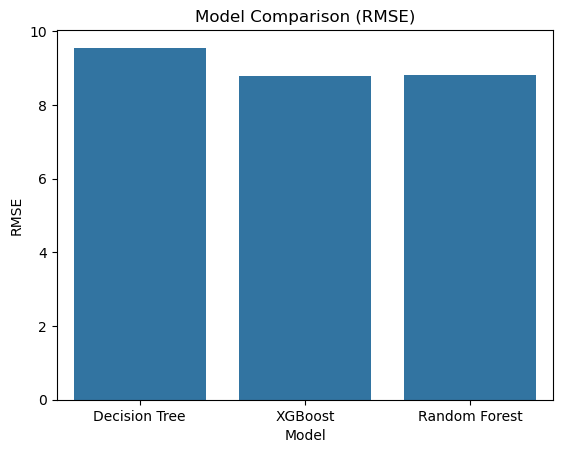

In [49]:
results = pd.DataFrame({
    "Model": ["Decision Tree", "XGBoost", "Random Forest"],
    "RMSE": [dt_rmse, xgb_rmse, rf_rmse],
    "MAE": [dt_mae, xgb_mae, rf_mae],
    "R²": [dt_r2, xgb_r2, rf_r2],
})

print(results)

sns.barplot(data=results, x="Model", y="RMSE")
plt.title("Model Comparison (RMSE)")
plt.show()


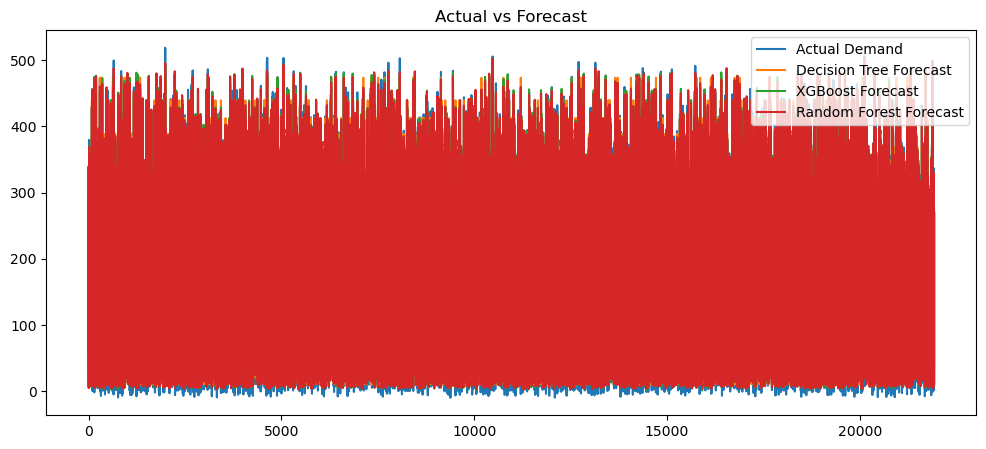

In [51]:
# Forecast Visualization

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual Demand")
plt.plot(dt_preds, label="Decision Tree Forecast")
plt.plot(xgb_preds, label="XGBoost Forecast")
plt.plot(rf_preds, label="Random Forest Forecast")
plt.legend()
plt.title("Actual vs Forecast")
plt.show()


In [53]:
# --- Function to evaluate models with percentages ---
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred) * 100

    mean_actual = np.mean(y_true)
    mse_pct  = (mse / (mean_actual ** 2)) * 100
    rmse_pct = (rmse / mean_actual) * 100

    print(f"\n{name} Performance:")
    print(f"  MSE   : {mse:.2f}   ({mse_pct:.2f}%)")
    print(f"  RMSE  : {rmse:.2f}  ({rmse_pct:.2f}%)")
    print(f"  R²    : {r2:.2f}%")
    
    return mse, rmse, r2, mse_pct, rmse_pct


In [55]:
dt_metrics_demand = evaluate_model("Decision Tree", y_test, dt_preds)
xgb_metrics_demand = evaluate_model("XGBoost", y_test, xgb_preds)
rf_metrics_demand  = evaluate_model("Random Forest", y_test, rf_preds)

# Compare Actual vs Predicted
results_df_demand = pd.DataFrame({
    "Actual": y_test,
    "DecisionTree_Pred": dt_preds,
    "XGBoost_Pred": xgb_preds,
    "RandomForest_Pred": rf_preds
}).reset_index(drop=True)

print("\nSample of Actual vs Predicted (Demand):")
print(results_df_demand.head(10))



Decision Tree Performance:
  MSE   : 91.33   (0.45%)
  RMSE  : 9.56  (6.75%)
  R²    : 99.23%

XGBoost Performance:
  MSE   : 77.30   (0.39%)
  RMSE  : 8.79  (6.21%)
  R²    : 99.35%

Random Forest Performance:
  MSE   : 77.69   (0.39%)
  RMSE  : 8.81  (6.22%)
  R²    : 99.35%

Sample of Actual vs Predicted (Demand):
   Actual  DecisionTree_Pred  XGBoost_Pred  RandomForest_Pred
0   73.46          79.715823     83.817467          84.936397
1  338.72         329.184004    340.071838         336.983621
2   58.93          68.802151     64.853172          65.644756
3    8.99          10.571830      5.325881           4.719934
4  287.47         292.267702    291.203033         292.612505
5   94.88         102.519968    100.634537         101.222720
6   49.98          57.964723     61.908363          61.690553
7   73.25          79.715823     80.108284          79.347475
8   41.57          40.546034     40.898460          42.273870
9  103.57         113.584766    113.921410         113.23704

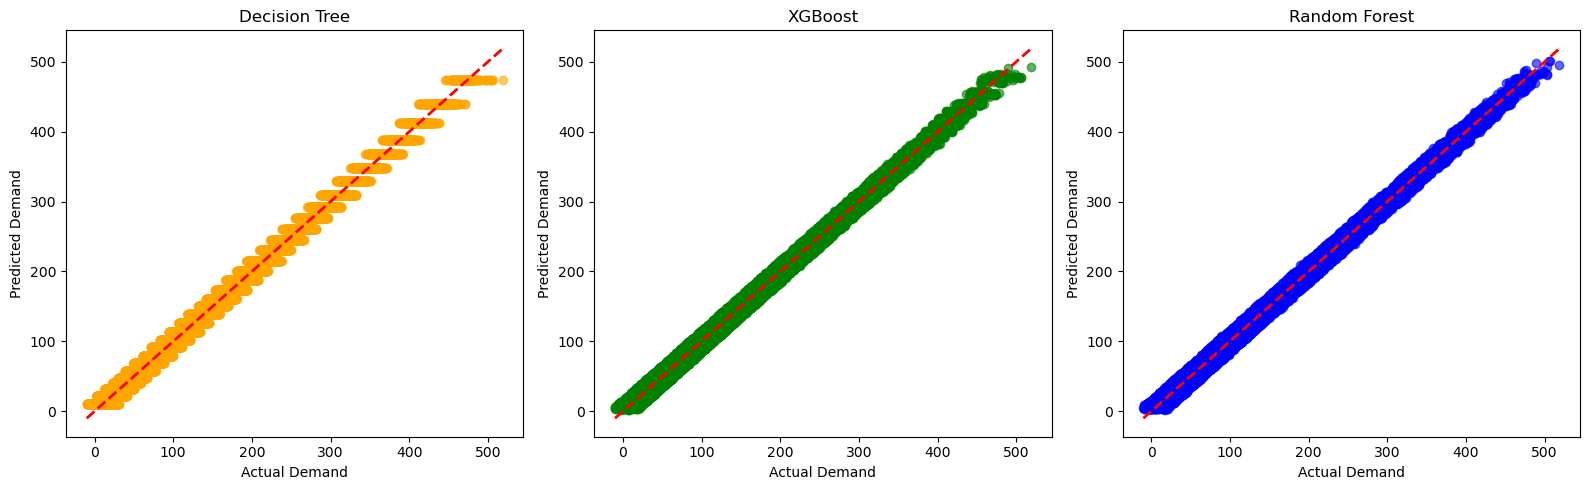

In [57]:
# Plot Actual vs Predicted for all demand models
plt.figure(figsize=(16, 5))

# --- Decision Tree ---
plt.subplot(1, 3, 1)
plt.scatter(y_test, dt_preds, alpha=0.6, color="orange")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2)
plt.title("Decision Tree")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")

# --- XGBoost ---
plt.subplot(1, 3, 2)
plt.scatter(y_test, xgb_preds, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2)
plt.title("XGBoost")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")

# --- Random Forest ---
plt.subplot(1, 3, 3)
plt.scatter(y_test, rf_preds, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2)
plt.title("Random Forest")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")

plt.tight_layout()
plt.show()


***Sales Revenue Forecast***

In [60]:
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,3,1,231,127,55,135.47,33.50,20,1,0,29.69,0
1,2022-01-01,S001,P0002,4,2,204,150,66,144.04,63.01,20,3,0,66.16,0
2,2022-01-01,S001,P0003,4,3,102,65,51,74.02,27.99,10,3,1,31.32,2
3,2022-01-01,S001,P0004,4,1,469,61,164,62.18,32.72,10,0,1,34.74,0
4,2022-01-01,S001,P0005,1,0,166,14,135,9.26,73.64,0,3,0,68.95,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,2,0,96,8,127,18.46,73.73,20,2,0,72.45,3
73096,2024-01-01,S005,P0017,4,1,313,51,101,48.43,82.57,10,0,0,83.78,0
73097,2024-01-01,S005,P0018,0,3,278,36,151,39.65,11.11,10,1,0,10.91,3
73098,2024-01-01,S005,P0019,4,0,374,264,21,270.52,53.14,20,1,0,55.80,1


In [62]:
df["Sales Amount"] = df["Units Sold"] * df["Price"]
df[["Date", "Units Sold", "Price", "Sales Amount"]].head()



,Date,Units Sold,Price,Sales Amount
0,2022-01-01,127,33.50,4254.50
1,2022-01-01,150,63.01,9451.50
2,2022-01-01,65,27.99,1819.35
3,2022-01-01,61,32.72,1995.92
4,2022-01-01,14,73.64,1030.96


C:\Users\USER\AppData\Local\Temp\ipykernel_13700\1677252383.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample("M", on="Date")["Sales Amount"].sum().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_13700\1677252383.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_sales = df.resample("Y", on="Date")["Sales Amount"].sum().reset_index()


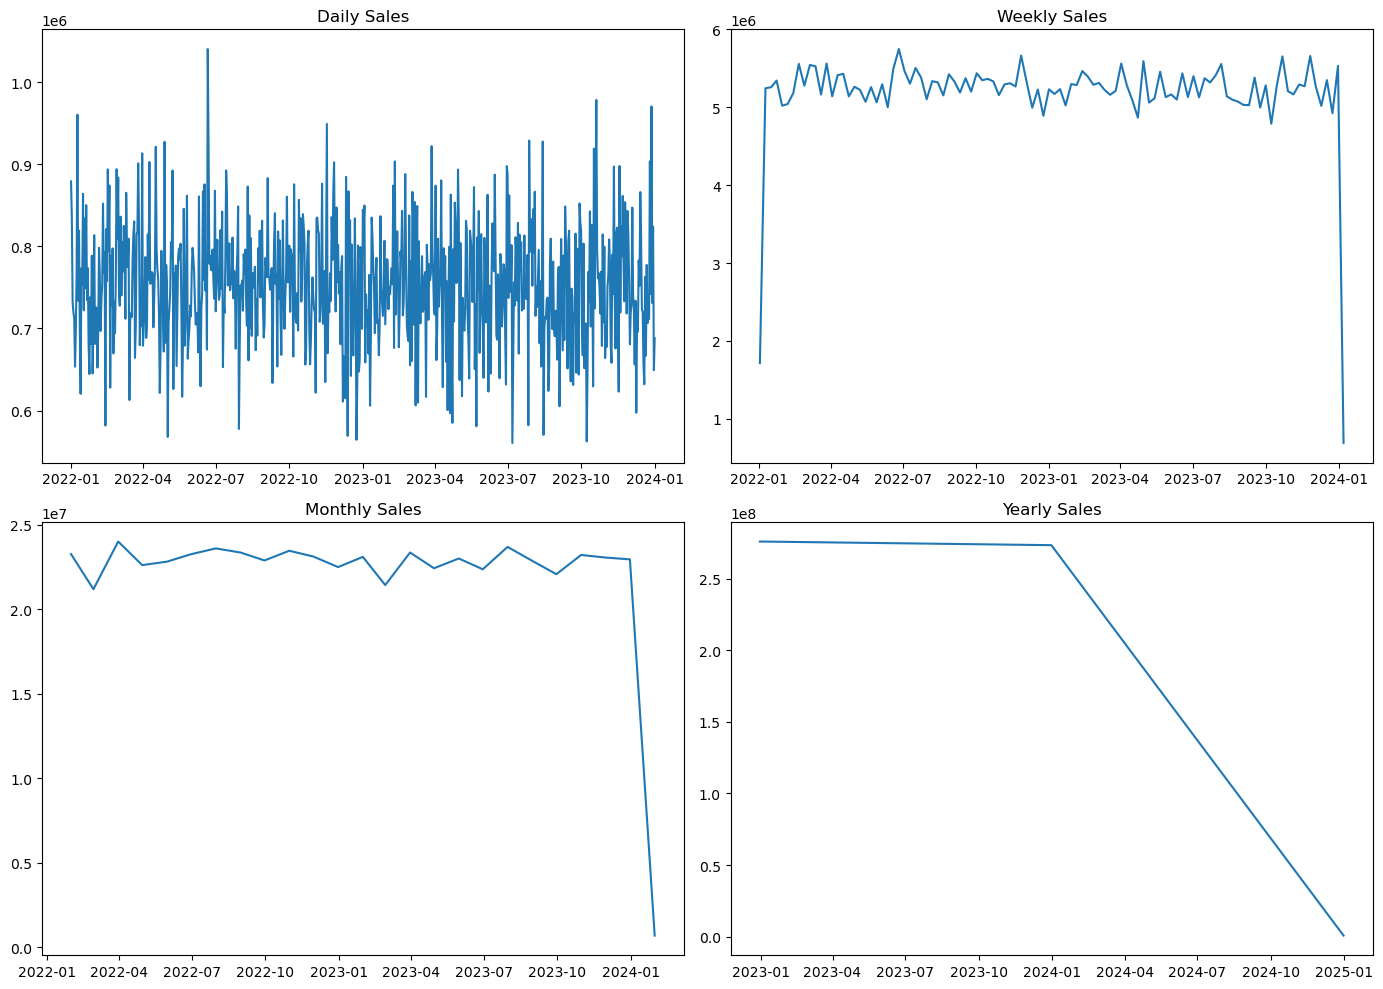

In [64]:
# Daily Sales (already in dataset)
daily_sales = df.groupby("Date")["Sales Amount"].sum().reset_index()

# Weekly Sales
weekly_sales = df.resample("W", on="Date")["Sales Amount"].sum().reset_index()

# Monthly Sales
monthly_sales = df.resample("M", on="Date")["Sales Amount"].sum().reset_index()

# Yearly Sales
yearly_sales = df.resample("Y", on="Date")["Sales Amount"].sum().reset_index()

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes[0,0].plot(daily_sales["Date"], daily_sales["Sales Amount"]); axes[0,0].set_title("Daily Sales")
axes[0,1].plot(weekly_sales["Date"], weekly_sales["Sales Amount"]); axes[0,1].set_title("Weekly Sales")
axes[1,0].plot(monthly_sales["Date"], monthly_sales["Sales Amount"]); axes[1,0].set_title("Monthly Sales")
axes[1,1].plot(yearly_sales["Date"], yearly_sales["Sales Amount"]); axes[1,1].set_title("Yearly Sales")
plt.tight_layout()
plt.show()




In [66]:
target_sales = "Sales Amount"
X = df[features]
y_sales = df[target_sales]


In [68]:
X

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Competitor Pricing,Category,Region,Weather Condition,Seasonality,Holiday/Promotion
0,231,127,55,33.50,20,29.69,3,1,1,0,0
1,204,150,66,63.01,20,66.16,4,2,3,0,0
2,102,65,51,27.99,10,31.32,4,3,3,2,1
3,469,61,164,32.72,10,34.74,4,1,0,0,1
4,166,14,135,73.64,0,68.95,1,0,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...
73095,96,8,127,73.73,20,72.45,2,0,2,3,0
73096,313,51,101,82.57,10,83.78,4,1,0,0,0
73097,278,36,151,11.11,10,10.91,0,3,1,3,0
73098,374,264,21,53.14,20,55.80,4,0,1,1,0


In [70]:
y_sales

0         4254.50
1         9451.50
2         1819.35
3         1995.92
4         1030.96
           ...   
73095      589.84
73096     4211.07
73097      399.96
73098    14028.96
73099      470.34
Name: Sales Amount, Length: 73100, dtype: float64

In [72]:
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.3, shuffle=False)


In [74]:
# --- Decision Tree ---
dt_model_sales = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model_sales.fit(X_train, y_train_sales)
dt_preds_sales = dt_model_sales.predict(X_test)


In [76]:
# --- XGBoost ---
xgb_model_sales = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model_sales.fit(X_train, y_train_sales)
xgb_preds_sales = xgb_model_sales.predict(X_test)


In [79]:
# --- Random Forest ---
rf_model_sales = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model_sales.fit(X_train, y_train_sales)
rf_preds_sales = rf_model_sales.predict(X_test)




In [81]:
dt_metrics = evaluate_model("Decision Tree", y_test_sales, dt_preds_sales)
xgb_metrics = evaluate_model("XGBoost", y_test_sales, xgb_preds_sales)
rf_metrics  = evaluate_model("Random Forest", y_test_sales, rf_preds_sales)


# --- Show Actual vs Predicted for comparison ---
results_df = pd.DataFrame({
    "Actual": y_test_sales,
    "DecisionTree_Pred": dt_preds_sales,
    "XGBoost_Pred": xgb_preds_sales,
    "RandomForest_Pred": rf_preds_sales
}).reset_index(drop=True)

print("\nSample of Actual vs Predicted:")
print(results_df.head(10))




Decision Tree Performance:
  MSE   : 1879023.07   (3.36%)
  RMSE  : 1370.77  (18.32%)
  R²    : 96.69%

XGBoost Performance:
  MSE   : 16590.27   (0.03%)
  RMSE  : 128.80  (1.72%)
  R²    : 99.97%

Random Forest Performance:
  MSE   : 10617.78   (0.02%)
  RMSE  : 103.04  (1.38%)
  R²    : 99.98%

Sample of Actual vs Predicted:
    Actual  DecisionTree_Pred  XGBoost_Pred  RandomForest_Pred
0  4748.69        5875.067978   4804.937988        4626.690602
1  7489.17        9358.538587   7234.053223        7557.977848
2  4765.93        4127.283473   4714.978516        4784.888453
3     0.00         246.828205    -37.109432           0.000000
4  9654.68       12043.423659   9596.137695        9680.649516
5  1952.25        2053.226310   2060.766357        1933.849421
6  4628.98        4127.283473   4614.760254        4556.339644
7  3489.16        2838.926772   3426.756348        3542.900705
8  2099.30        2420.107726   2217.200684        2082.994303
9  1789.56        2053.226310   1897.912

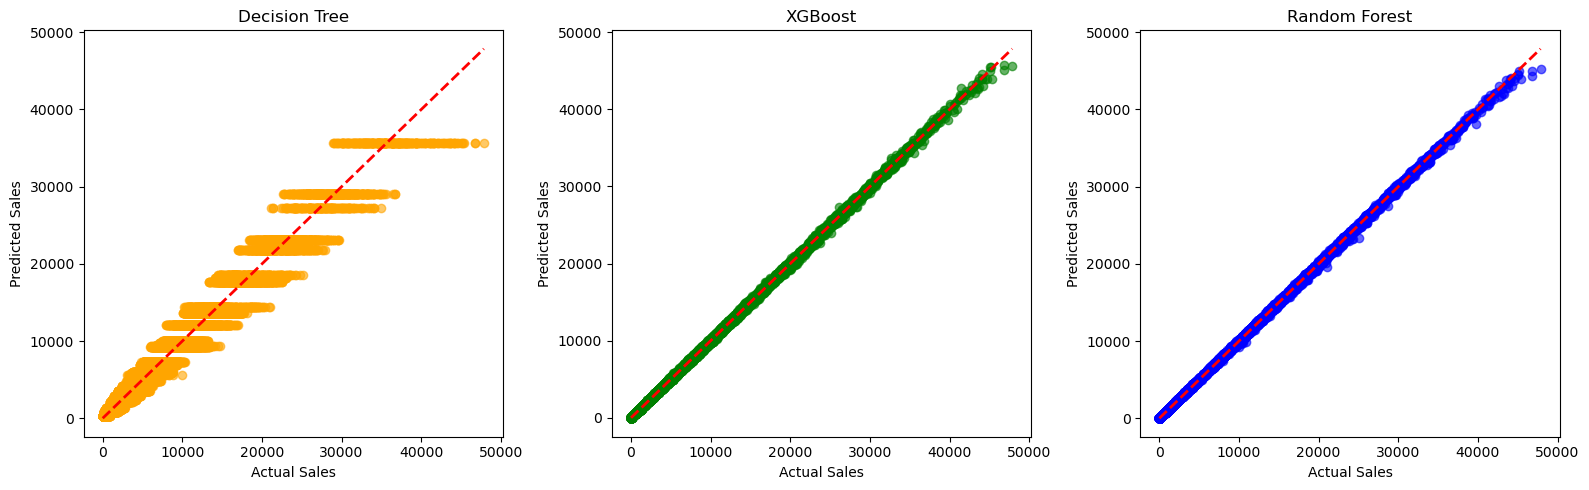

In [83]:
# Plot Actual vs Predicted for all models
plt.figure(figsize=(16, 5))

# --- Decision Tree ---
plt.subplot(1, 3, 1)
plt.scatter(y_test_sales, dt_preds_sales, alpha=0.6, color="orange")
plt.plot([y_test_sales.min(), y_test_sales.max()],
         [y_test_sales.min(), y_test_sales.max()],
         "r--", lw=2)
plt.title("Decision Tree")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")

# --- XGBoost ---
plt.subplot(1, 3, 2)
plt.scatter(y_test_sales, xgb_preds_sales, alpha=0.6, color="green")
plt.plot([y_test_sales.min(), y_test_sales.max()],
         [y_test_sales.min(), y_test_sales.max()],
         "r--", lw=2)
plt.title("XGBoost")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")

# --- Random Forest ---
plt.subplot(1, 3, 3)
plt.scatter(y_test_sales, rf_preds_sales, alpha=0.6, color="blue")
plt.plot([y_test_sales.min(), y_test_sales.max()],
         [y_test_sales.min(), y_test_sales.max()],
         "r--", lw=2)
plt.title("Random Forest")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")

plt.tight_layout()
plt.show()

In [85]:
joblib.dump(rf_model_sales, "best_sales_model.pkl")
joblib.dump(xgb_model, "best_demand_model.pkl")

# Save encoders (if you used LabelEncoder)
joblib.dump(encoders, "label_encoders.pkl")

print("✅ Random Forest model saved as best_sales_model.pkl")
print("✅ XGBoost model for demand forecast saved as best_demand_model.pkl")
print("✅ Label encoders saved as label_encoders.pkl")


✅ Random Forest model saved as best_sales_model.pkl
✅ XGBoost model for demand forecast saved as best_demand_model.pkl
✅ Label encoders saved as label_encoders.pkl
